# Detailed run visualizer - report generator
This notebook generates a detailed overview of all the metrics for a run. This can be used to identify bottlenecks.

In [1]:
# settings for saving plots
saveplots = True
dpiResolution = 100
paperStylePlots = True 

In [2]:
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
# Import to indent the plots in the notebook
%matplotlib notebook
%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import seaborn as sns
from IPython.core.display import display, HTML
from PIL import Image
warnings.simplefilter('ignore', Image.DecompressionBombWarning)
import datetime
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
from pyspark.sql import Window
from pyspark.sql import functions
from pyspark.sql.types import IntegerType, LongType, DoubleType, TimestampType, StringType

In [4]:
# settings to get plots in the right style
plt.style.use('ggplot')
plt.style.use('seaborn-deep')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'lightgrey'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'normal'
plt.rcParams['figure.edgecolor'] = 'lightgrey'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.edgecolor'] = 'white'
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.titleweight'] ='bold'
plt.rcParams['grid.color'] = 'black'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] ='out'
plt.rcParams["date.autoformatter.minute"] = "%H:%M"
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('axes',edgecolor='black')

In [5]:
frameworksPrinted = {
    "SPARK": "Spark Streaming",
    "STRUCTUREDSTREAMING": "Structured Streaming",
    "FLINK": "Flink",
    "KAFKASTREAMS": "Kafka Streams"
}
stages=["ingest", "parse", "join", "tumbling \n window", "sliding \n window"]

In [6]:
def dataRate(factor, last_stage):
    if(int(last_stage) > 99):
        return 190*(int(factor)+1)
    else :
        return 380*(int(factor)+1)

dataRateUDF = functions.udf(dataRate, IntegerType())

In [7]:
def save_img_colored_and_grayscale(path_colored_img, tightness=True):
    if saveplots: 
        if tightness: 
            plt.savefig(path_colored_img + '.png', dpi=dpiResolution, bbox_inches="tight", pad_inches = 0)
        else: 
            plt.savefig(path_colored_img + '.png', dpi=dpiResolution, pad_inches = 0)

In [8]:
def printTimeseriesChartNew(framework, workload, last_stage,scale, run, cpu_amt, printCharts = True):
    print(framework + "/" + workload + "/" + last_stage + "/" + scale + "/" + run)
    dataPath = "./scalability-data/" + workload + "/" + framework + "/stage" + last_stage + "/" + scale + "/" + run

    resultData = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/results.csv/*").select("scale", "p50", "p99", "mean_cpu", "count")\
        .withColumn("TP", dataRateUDF(col("scale"), lit(last_stage)))\
        .withColumn("mean_cpu_pct", round(100*col("mean_cpu")/cpu_amt))
    resultData.show()
 
    cadvisorData = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/cadvisor-metrics-per-container-timeseries.csv/*")\
        .withColumn("TP", dataRateUDF(col("scale"), lit(last_stage)))\
        .withColumn("timeSec", (col("time")-col("startTime"))/60000) \
        .filter((col("timeSec") < 30) & (col("timeSec")>3)) 
    hdfsCadvisorData = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/hdfs-cadvisor-metrics-per-container-timeseries.csv/*")\
        .withColumn("TP", dataRateUDF(col("scale"), lit(last_stage)))\
        .withColumn("timeSec", (col("time")-col("startTime"))/60000) \
        .filter((col("timeSec") < 30) & (col("timeSec")>3)) 
    kafkaCadvisorData = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/kafka-cadvisor-metrics-per-container-timeseries.csv/*")\
        .withColumn("TP", dataRateUDF(col("scale"), lit(last_stage)))\
        .withColumn("timeSec", (col("time")-col("startTime"))/60000) \
        .filter((col("timeSec") < 30) & (col("timeSec")>3)) 
        
    cadvisorPd= cadvisorData.toPandas()
    startTime = cadvisorPd["startTime"][0]
    
    volume = resultData.select("scale").toPandas()["scale"][0]
    
    pp = PdfPages("./figures/" + workload + "/overall/REPORT_phase" + str(last_stage) + "_" + str(scale) + "_" + framework + "_volume" + str(volume))
    
    # latency, cpu, mem plot
    f, ax = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
    minor_x_locator = AutoMinorLocator(5)
    pad = 5
    
    
    print("CORE METRICS")
    print("---------------------")
    
    ## LATENCY
    try:
        latencyTimeseriesDataPhase = spark.read.option("header", "true").option("inferSchema", "true") \
            .csv(dataPath + "/latency-timeseries-data-without-startup.csv/*") \
            .withColumn("timeSec", (col("outputBucketTime")-col("startTime"))/60000) \
            .filter(col("timeSec") < 30)

        percentilesPandas = latencyTimeseriesDataPhase.orderBy("timeSec").toPandas()
#         ax.fill_between(percentilesPandas["timeSec"], percentilesPandas["percentile_50_second"], percentilesPandas["percentile_99_second"], \
#                        facecolor='grey', interpolate=True, alpha=0.5)
        pct50_line, = ax[0].plot(percentilesPandas["timeSec"], percentilesPandas["percentile_50_second"], color="grey", label = "median")
        pct99_line, = ax[0].plot(percentilesPandas["timeSec"], percentilesPandas["percentile_99_second"], color="black", label = "p99")
        ax[0].set_ylabel("latency")
        ax[0].set_ylim(ymin=0)
        ax[0].xaxis.set_minor_locator(minor_x_locator)
        minor_y_locator_1 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
        ax[0].yaxis.set_minor_locator(minor_y_locator_1)
    #     ax[0].set_yticks([0, 3000, 15000])
        ax[0].grid(which='minor', color='black')
        ax[0].get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ') + " s"))
    except:
        print("no latency data?")
        
    ## CPU
    cpuTimeseriesPerContainer = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/cpu-per-container-timeseries.csv/*") \
        .withColumn("timeSec", (col("time") - col("startTime"))/60000) \
        .filter(col("timeSec") < 30)
    containersPandas = cpuTimeseriesPerContainer.select("containerName").distinct().orderBy("containerName").toPandas()
    rgb_values = sns.husl_palette(len(containersPandas), h=0.4, l=0.65, s=1) 
    color_map = dict(zip(containersPandas['containerName'], rgb_values))
    cpuTimeseriesPerContainerPandas = cpuTimeseriesPerContainer.toPandas()
    for contNum, containerId in enumerate(containersPandas['containerName']):
        data = cpuTimeseriesPerContainerPandas.loc[cpuTimeseriesPerContainerPandas['containerName'] == containerId]
        cpu_worker_line_1 = ax[1].scatter(data['timeSec'], data['cpuUsagePct'], c=color_map[containerId], s = 3)
    ax[1].set_ylabel("CPU")
    cpu_threshold = ax[1].axhline(y=80, color="black")
    p50_cpu = resultData.select("mean_cpu_pct").toPandas()["mean_cpu_pct"][0]
    p50_cpu_line = ax[1].axhline(y=p50_cpu, color="black", linestyle = "--")
    ax[1].set_ylim(ymin=0, ymax=110)
    ax[1].set_yticks([0, 50, 100])
    ax[1].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[1].yaxis.set_minor_locator(minor_y_locator_3)
    ax[1].grid(which='minor', color='black')
    ax[1].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " %"))
    
    ## MEMORY  
    memTimeseriesPerContainer = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/resources-per-container-timeseries.csv/*") \
        .withColumn("timeSec", (col("time") - col("startTime"))/60000) \
        .filter((col("timeSec") < 30)) # & (col('containerName') == "spark-worker-2" )

    memTimeseriesPerContainerPandas = memTimeseriesPerContainer.toPandas()
    for contNum, containerId in enumerate(containersPandas['containerName']):
        data = memTimeseriesPerContainerPandas.loc[memTimeseriesPerContainerPandas['containerName'] == containerId]
        mem_worker_line_1, = ax[2].plot(data['timeSec'], data['heapUsageMB'], c=color_map[containerId])
    ax[2].set_ylabel("memory")
    ax[2].set_ylim(ymin=0)
    ax[2].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[2].yaxis.set_minor_locator(minor_y_locator_3)
    ax[2].grid(which='minor', color='black')
    ax[2].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x/1024.0)) + " GB"))
    
    ax[2].set_xlabel("minute of run")
    
    ax[0].legend(loc = "upper right", ncol=3, bbox_to_anchor=(1, 1.45), framealpha=1.0, frameon=False)
    ax[1].legend([cpu_threshold, p50_cpu_line, cpu_worker_line_1], ["80% threshold", "p50", "workers"], handletextpad=0.1, loc = "upper right", ncol=4, bbox_to_anchor=(1, 1.50), framealpha=1.0, frameon=False, scatterpoints=1, markerscale=3)
    ax[2].legend([mem_worker_line_1], ["workers"], ncol = 2, loc = "upper right", bbox_to_anchor=(1, 1.50), frameon=False, scatterpoints=1, markerscale=3)

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=0.25, hspace=0.5)
    save_img_colored_and_grayscale("./figures/" + workload + "/overall/phase" + str(last_stage) + "_" + str(scale) + "_" + framework + "_volume" + str(volume))
    pp.savefig()
    if (printCharts): 
        plt.show()   
    else:
        plt.close() 
    
    
    
    print("SYSTEM LOAD AVERAGE")
    print("---------------------")
    f, ax = plt.subplots(1, 1,figsize=(7, 3))
 
    ax.set_title("System load average")
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = memTimeseriesPerContainerPandas.loc[memTimeseriesPerContainerPandas['containerName'] == containerId]
        ax.plot(data['timeSec'], data['systemLoadAverage'], label = containerNameCore, c=color_map[containerId])
    ax.set_ylim(ymin=0)
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax.yaxis.set_minor_locator(minor_y_locator_3)
    ax.xaxis.set_minor_locator(minor_x_locator)
    ax.grid(which='minor', color='black')
    
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=0.25, hspace=0.5)
    if (printCharts): 
        plt.show()  
    else:
        plt.close()
    
    
    
    minor_x_locator = AutoMinorLocator(2)
    
    print("CORE METRICS")
    print("---------------------")
    figheight = 3.2
    figwidth = 12
    
    f, ax = plt.subplots(1, 3,figsize=(figwidth, figheight))

    i=0
    ax[i].set_title('Latency') 
    pct50_line, = ax[i].plot(percentilesPandas["timeSec"], percentilesPandas["percentile_50_second"], color="grey", label = "median latency")
    pct99_line, = ax[i].plot(percentilesPandas["timeSec"], percentilesPandas["percentile_99_second"], color="black", label = "p99 latency")
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_1 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_1)
#     ax[0].set_yticks([0, 3000, 15000])
    ax[i].grid(which='minor', color='black')
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/1000.0), ',').replace(',', ' ') + " s"))

    
    i=1
    ax[i].set_title('CPU total')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        data = cpuTimeseriesPerContainerPandas.loc[cpuTimeseriesPerContainerPandas['containerName'] == containerId]
        cpu_worker_line_1 = ax[1].scatter(data['timeSec'], data['cpuUsagePct'], label='_no_legend', c=color_map[containerId], s = 3)
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x) + "%"))
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].grid(which='minor', color='black')
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].set_yticks([0, 50, 100])
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)
    
    cpu_threshold = ax[i].axhline(y=80, color="black")
    p50_cpu = resultData.select("mean_cpu_pct").toPandas()["mean_cpu_pct"][0]
    p50_cpu_line = ax[i].axhline(y=p50_cpu, color="black", linestyle = "--")
    ax[i].set_ylim(ymin=0, ymax=110)


    i=2
    ax[i].set_title('Heap memory')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = memTimeseriesPerContainerPandas.loc[memTimeseriesPerContainerPandas['containerName'] == containerId]
        mem_worker_line_1, = ax[2].plot(data['timeSec'], data['heapUsageMB']/1024, c=color_map[containerId], label=containerNameCore)
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " GB"))

    plt.tight_layout(rect=[0, 0, 1, 1])
    f.legend(ncol = 4, loc = "upper right", bbox_to_anchor=(1, 1), frameon=False, scatterpoints=1, markerscale=3)

    plt.subplots_adjust(top=0.57, wspace=0.25, hspace=0.7)
    save_img_colored_and_grayscale("./figures/" + workload + "/overall/phase" + str(last_stage) + "_" + str(scale) + "_" + framework + "_volume" + str(volume) + "_core", False)
    pp.savefig()
    if (printCharts): 
        plt.show() 
    else:
        plt.close()
    
    print("CPU")
    print("---------------------")
    figheight = 2
    figwidth = 12
    
    ## CPU
    f, ax = plt.subplots(1, 3,figsize=(figwidth, figheight))

    i=0
    ax[i].set_title('CPU system')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[i].plot(data['timeSec'], data['cpu_system_pct'], label='_nolegend_', c=color_map[containerId])
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x) + "%"))
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].grid(which='minor', color='black')
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)
    
    i=1
    ax[i].set_title('CPU user')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[i].plot(data['timeSec'], data['cpu_user_pct'], label='_nolegend_', c=color_map[containerId])
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x) + "%"))
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].grid(which='minor', color='black')
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].set_yticks([0, 50, 100])
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)


    i=2
    ax[i].set_title('CPU others')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        container_line = ax[i].plot(data['timeSec'], data['cpu_others_pct'], label=containerNameCore, c=color_map[containerId])
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x) + "%"))
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)

    plt.tight_layout(rect=[0, 0, 1, 1])
#     f.legend(ncol = 4, loc = "upper right", bbox_to_anchor=(1, 1), frameon=False, scatterpoints=1, markerscale=3)

    plt.subplots_adjust(wspace=0.25)
    save_img_colored_and_grayscale("./figures/" + workload + "/overall/phase" + str(last_stage) + "_" + str(scale) + "_" + framework + "_volume" + str(volume) + "_cpu")
    pp.savefig()
    if (printCharts):
        plt.show()
    else:
        plt.close()

    print("MEMORY")
    print("---------------------")
    figheight = 2
    figwidth = 12
    f, ax = plt.subplots(1, 3,figsize=(figwidth, figheight))


    i=0
    ax[i].set_title("Memory RSS")
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[i].plot(data['timeSec'], data['memory_rss_MB']/1024, label='_nolegend_', c=color_map[containerId])
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x).replace(".0", "") + " GB"))
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')

    i=1
    ax[i].set_title("Cache usage")
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[i].plot(data['timeSec'], data['memory_cache_MB']/1024, label='_nolegend_', c=color_map[containerId])
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x).replace(".0", "") + " GB"))
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')

    i=2
    ax[i].set_title("Page faults")
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[i].plot(data['timeSec'], data['memory_pgfault'], label='_nolegend_', c=color_map[containerId])
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')


    plt.tight_layout(rect=[0, 0, 1, 1])
#     f.legend(ncol = 4, loc = "upper right", bbox_to_anchor=(1, 1), frameon=False, scatterpoints=1, markerscale=3)
    plt.subplots_adjust(wspace=0.3, hspace=0.55)
    save_img_colored_and_grayscale("./figures/" + workload + "/overall/phase" + str(last_stage) + "_" + str(scale) + "_" + framework + "_volume" + str(volume) + "_memory")
    pp.savefig()
    if (printCharts):
        plt.show()
    else:
        plt.close()
    
    
     ## GC
    figheight = 4
    figwidth = 12
    print("GC")
    print("---------------------")
    gcStats = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/gc-collects.csv/*") \
        .withColumn("timeSec", (col("time") - col("startTime"))/60000) \
        .filter((col("timeSec") < 30) & (col("timeSec")>3))         
        
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    allGC = gcStats.toPandas()
    minorGC = gcStats.filter(col("name").contains("Young")).toPandas()
    fullGC = gcStats.filter(col("name").contains("Old")).toPandas()

    # PLOT G1 YOUNG GEN
    f, ax = plt.subplots(2, 3,figsize=(figwidth, figheight))
#     f.suptitle("GC METRICS", y = 1.22, fontsize=18, fontweight=1000)
    
    i = 0
    j = 0
    ax[i,j].set_title('G1 Young Generation: last GC duration')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = minorGC.loc[minorGC['containerName'] == containerId]
        ax[i,j].plot(data['timeSec'], data['lastGcDuration'], label='_nolegend_', c=color_map[containerId])
    ax[i,j].set_ylabel("ms")
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)


    i = 0
    j = 1
    # PLOT G1 OLD GEN
    ax[i,j].set_title('G1 Old Generation: last GC duration')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = fullGC.loc[fullGC['containerName'] == containerId]
        ax[i,j].scatter(data['timeSec'], data['lastGcDuration'], label='_nolegend_', c=color_map[containerId])
    ax[i,j].set_ylabel("ms")
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)

    memoryPoolData1 = gcStats.select("containerName", "timeSec", "G1EdenAfter", "G1SurvivorAfter", "G1OldGenAfter")\
         .toDF("containerName", "timeSec", "G1Eden", "G1Survivor", "G1OldGen")

    memoryPoolData2 = gcStats.withColumn("timeSec", col("timeSec")-(col("lastGcDuration")/60000))\
        .select("containerName", "timeSec", "G1EdenBefore", "G1SurvivorBefore", "G1OldGenBefore")\
        .toDF("containerName", "timeSec", "G1Eden", "G1Survivor", "G1OldGen")
    memoryPoolData = memoryPoolData1.union(memoryPoolData2).orderBy("timeSec").toPandas()

    i = 0
    j = 2
    gcCollectionTime = spark.read.option("header", "true").option("inferSchema", "true") \
        .csv(dataPath + "/gc-time-per-memory-pool.csv/*") \
        .withColumn("timeSec", (col("time") - col("startTime"))/60000) \
        .filter((col("timeSec") < 30) & (col("timeSec")>3)) \
        
    youngGcCollectionTime = gcCollectionTime.filter(col("name") == "G1 Young Generation")
    oldGcCollectionTime = gcCollectionTime.filter(col("name") == "G1 Old Generation")\
        .withColumn("nextOldGcTime", lead("timeSec").over(Window.partitionBy("containerName").orderBy("timeSec")))\
        .select(col("timeSec").alias("oldGcTimeSec"), 
                col("nextOldGcTime"), 
                col("containerName").alias("oldContainerName"), 
                col("collectionTime").alias("oldCollectionTime"))

    totalCollectionTimeDF =youngGcCollectionTime.join(oldGcCollectionTime, (youngGcCollectionTime.timeSec<oldGcCollectionTime.nextOldGcTime) 
                               & (youngGcCollectionTime.timeSec>=oldGcCollectionTime.oldGcTimeSec)
                              & (youngGcCollectionTime.containerName==oldGcCollectionTime.oldContainerName))\
            .withColumn("totalCollectionTime", col("collectionTime")+ col("oldCollectionTime"))

    gcCollectionTimePd = totalCollectionTimeDF.toPandas()

    ax[i,j].set_title('GC Collection Time')

    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        gcData = gcCollectionTimePd.loc[gcCollectionTimePd['containerName'] == containerId]
#             .loc[gcCollectionTimePd['name'] == "G1 Young Generation"]
        ax[i,j].plot(gcData['timeSec'], gcData['totalCollectionTime'], label='_nolegend_', c=color_map[containerId])
    ax[i,j].set_ylabel("ms")
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)
    
    i = 1
    j = 0
    ax[i,j].set_title('Memory Pools: G1 Eden')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        gcData = memoryPoolData.loc[memoryPoolData['containerName'] == containerId]
        ax[i,j].plot(gcData['timeSec'], gcData['G1Eden']/(1024**3), label=containerNameCore, c=color_map[containerId])
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)
    ax[i,j].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x) + " GB"))
    
    i = 1
    j = 1
    ax[i,j].set_title('Memory Pools: Old Generation')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        gcData = memoryPoolData.loc[memoryPoolData['containerName'] == containerId]
        ax[i,j].plot(gcData['timeSec'], gcData['G1OldGen']/(1024**3), label='_nolegend_', c=color_map[containerId])
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)
    ax[i,j].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x) + " GB"))
    
    i = 1
    j = 2
    ax[i,j].set_title('Memory Pools: G1 Survivor')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        gcData = memoryPoolData.loc[memoryPoolData['containerName'] == containerId]
        ax[i,j].plot(gcData['timeSec'], gcData['G1Survivor']/(1024**3), label='_nolegend_', c=color_map[containerId])
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2) # how many minor grid lines in between two major grid lines for y axis
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)
    ax[i,j].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(x) + " GB"))


    plt.tight_layout(rect=[0, 0, 1, 1])
#     f.legend(ncol = 4, loc = "upper right", bbox_to_anchor=(1, 1), frameon=False, scatterpoints=1, markerscale=3)
    plt.subplots_adjust(wspace=0.3, hspace=0.55)
    save_img_colored_and_grayscale("./figures/" + workload + "/overall/phase" + str(last_stage) + "_" + str(scale) + "_" + framework + "_volume" + str(volume) +"_GC")
    pp.savefig()
    if (printCharts):
        plt.show() 
    else:
        plt.close()
    
          
    ## FILESYSTEM
    figwidth = 12
    figheight = 2
    print("FILESYSTEM and DISK")
    print("---------------------")
    f, ax = plt.subplots(1, 3,figsize=(figwidth, figheight))
#     f.suptitle("DISK METRICS", y = 1.32, fontsize=18, fontweight=1000)
    
    i = 0
    ax[i].set_title('Filesystem usage')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[i].plot(data['timeSec'], data['fs_usage_MB']/1024, label='_no_legend', c=color_map[containerId])
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].set_ylabel("GB")
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)
    

    i = 1
    ax[i].set_title('Disk write per second')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[i].plot(data['timeSec'], data['diskio_bytes_write_per_second']/(1024**2), label='_no_legend', c=color_map[containerId])
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " MB"))
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)

    i = 2
    ax[i].set_title('Disk read per second')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[i].plot(data['timeSec'], data['diskio_bytes_read_per_second']/(1024), label=containerNameCore, c=color_map[containerId])
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " KB"))
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)

    plt.tight_layout(rect=[0, 0, 1, 1])
#     f.legend(ncol = 4, loc = "upper right", bbox_to_anchor=(1, 1), frameon=False, scatterpoints=1, markerscale=3)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    save_img_colored_and_grayscale("./figures/" + workload + "/overall/phase" + str(last_stage) + "_" + str(scale) + "_" + framework + "_volume" + str(volume) +"_disk")
    pp.savefig()
    if (printCharts):
        plt.show()
    else:
        plt.close()

    ## NETWORK 
    figwidth = 12
    figheight = 2
    print("NETWORK")
    print("---------------------")
    f, ax = plt.subplots(1, 3,figsize=(figwidth, figheight))
#     f.suptitle("NETWORK METRICS", y = 1.22, fontsize=18, fontweight=1000)
    
#     i = 0
    j = 0
    ax[j].set_title('Received bytes')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        rxdata = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[j].plot(rxdata['timeSec'], rxdata['network_rxMbitps'], label='_no_legend', c=color_map[containerId])
    ax[j].set_ylabel("Mbits/sec")
    ax[j].set_ylim(ymin=0)
    ax[j].set_xlim(xmin=0, xmax=30)
    ax[j].set_xticks([0,5,10,15,20,25,30])
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[j].yaxis.set_minor_locator(minor_y_locator_3)
    ax[j].xaxis.set_minor_locator(minor_x_locator)
    ax[j].grid(which='minor', color='black')

#     i = 0
    j = 1
    ax[j].set_title('Transmitted bytes')
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        txdata = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[j].plot(txdata['timeSec'], txdata['network_txMbitps'], label='_no_legend', c=color_map[containerId])
    ax[j].set_ylabel("Mbits/sec")
    ax[j].set_ylim(ymin=0)
    ax[j].set_xlim(xmin=0, xmax=30)
    ax[j].set_xticks([0,5,10,15,20,25,30])
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[j].yaxis.set_minor_locator(minor_y_locator_3)
    ax[j].xaxis.set_minor_locator(minor_x_locator)
    ax[j].grid(which='minor', color='black')
    
#     i = 1
    j = 2
    ax[j].set_title('Dropped packets')
    cadvisorPd['network_dropped'] = cadvisorPd['network_rx_dropped'] + cadvisorPd['network_tx_dropped']
    for contNum, containerId in enumerate(containersPandas['containerName']):
        containerNameCore = containerId.replace(".kafka-streams", "")
        data = cadvisorPd.loc[cadvisorPd['containerName'] == containerNameCore]
        ax[j].plot(data['timeSec'], data['network_dropped'], label=containerNameCore, c=color_map[containerId])    
    ax[j].set_ylabel("Packets/sec")
    ax[j].set_ylim(ymin=0)
    ax[j].set_xlim(xmin=0, xmax=30)
    ax[j].set_xticks([0,5,10,15,20,25,30])
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[j].yaxis.set_minor_locator(minor_y_locator_3)
    ax[j].xaxis.set_minor_locator(minor_x_locator)
    ax[j].grid(which='minor', color='black')
        
               
    plt.tight_layout(rect=[0, 0, 1, 1])
#     f.legend(ncol = 4, loc = "upper right", bbox_to_anchor=(1, 1), frameon=False, scatterpoints=1, markerscale=3)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    save_img_colored_and_grayscale("./figures/" + workload + "/overall/phase" + str(last_stage) + "_" + str(scale) + "_" + framework + "_volume" + str(volume) +"_network")
    pp.savefig()
    if (printCharts):
        plt.show()
    else:
        plt.close()
    
    
    cadvisorData.agg(sum("network_rxMbitps").alias("total_rxMbits"), sum("network_txMbitps").alias("total_txMbits"))\
        .withColumn("total_rxGb", col("total_rxMbits")/1024).withColumn("total_txGb", col("total_txMbits")/1024).show()

    

    # TOTAL NETWORK
    print("TOTAL NETWORK")
    print("---------------------")
    try:
        f, ax = plt.subplots(1, 1,figsize=(7,3))
        # between EC2 instances
        averageNetworkLoad = spark.read\
            .option("multiLine", True)\
            .option("mode", "PERMISSIVE")\
            .json(dataPath + "/network/*average.json")\
            .withColumn("filename", substring_index(input_file_name(), "/", -1))\
            .withColumn("instance", split(col("filename"), "_").getItem(0))\
            .withColumn("metric", split(col("filename"), "_").getItem(1))\
            .withColumn("time", to_timestamp("Timestamp").cast("double")*1000)\
            .withColumn("timeSec", (col("time")- int(startTime))/60000)\
            .filter((col("timeSec") < 30) & (col("timeSec")>3)) \
            .drop("filename", "Unit")\
            .groupBy("timeSec", "instance")\
            .agg(sum(col("Average")).alias("Average"))\
            .withColumn("avgMbitps", round(col("Average")*8/60/1000/1000, 3))

        instances = averageNetworkLoad.select("instance").distinct().toPandas()["instance"]
        ax.set_title('EC2 instance network load')
        for instance in instances:
            avgLoadInstance = averageNetworkLoad.filter(col("instance") == instance).orderBy("timeSec").toPandas()
            ax.plot(avgLoadInstance['timeSec'], avgLoadInstance['avgMbitps'], label= instance)
        ax.set_xlabel("time")
        ax.xaxis.set_minor_locator(minor_x_locator)
        minor_y_locator_3 = AutoMinorLocator(2)
        ax.yaxis.set_minor_locator(minor_y_locator_3)
        ax.set_xlim(xmin=0, xmax=30)
        ax.set_xticks([0,5,10,15,20,25,30])
        ax.grid(which='minor', color='black')
        ax.set_ylabel("Mbps")

        plt.tight_layout(rect=[0, 0, 1, 1])
    #     f.legend(ncol = 4, loc = "upper right", bbox_to_anchor=(1, 1.1), frameon=False, scatterpoints=1, markerscale=3)
        plt.subplots_adjust(wspace=0.3, hspace=0.5)
        pp.savefig()
        
        if (printCharts):
            plt.show()
        else:
            plt.close()
    except:
        print("total network data was not okay")
    
          
    ## KAFKA
    figwidth = 12
    figheight = 5
    print("KAFKA")
    print("---------------------")
    f, ax = plt.subplots(2, 3,figsize=(figwidth, figheight))
    
    i = 0
    j = 0
    ax[i,j].set_title('Kafka CPU total usage')
    kafkaBrokerContainerIds = kafkaCadvisorData.select("containerName").distinct().toPandas()["containerName"]
    kafkaCadvisorPd = kafkaCadvisorData.toPandas()
    
    ax[i,j].set_title('CPU usage')
    for contNum, containerId in enumerate(kafkaBrokerContainerIds):
        data = kafkaCadvisorPd.loc[kafkaCadvisorPd['containerName'] == containerId]
        ax[i,j].plot(data['timeSec'], data['cpu_total'], label='_no_legend')
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].set_ylabel("cores")
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)
    
    i = 1
    j = 0
    ax[i,j].set_title('Disk IO: per second')
    for contNum, containerId in enumerate(kafkaBrokerContainerIds):
        data = kafkaCadvisorPd.loc[kafkaCadvisorPd['containerName'] == containerId]
        ax[i,j].plot(data['timeSec'], data['diskio_bytes_per_second']/(1024**2), label='_no_legend')
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " MB"))
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)

    i = 0
    j = 1
    ax[i,j].set_title('Memory RSS')
    for contNum, containerId in enumerate(kafkaBrokerContainerIds):
        data = kafkaCadvisorPd.loc[kafkaCadvisorPd['containerName'] == containerId]
        ax[i,j].plot(data['timeSec'], data['memory_rss_MB']/1024, label='_no_legend')
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " GB"))
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)

    i = 1
    j = 1
    ax[i,j].set_title('Memory cache')
    for contNum, containerId in enumerate(kafkaBrokerContainerIds):
        data = kafkaCadvisorPd.loc[kafkaCadvisorPd['containerName'] == containerId]
        ax[i,j].plot(data['timeSec'], data['memory_cache_MB']/1024, label="_no_legend")
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " GB"))
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)
    
    i = 0
    j = 2
    ax[i,j].set_title('Network: transmitted')
    for contNum, containerId in enumerate(kafkaBrokerContainerIds):
        data = kafkaCadvisorPd.loc[kafkaCadvisorPd['containerName'] == containerId]
        ax[i,j].plot(data['timeSec'], data['network_txMbitps'], label='_no_legend')
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].set_ylabel("Mbitps")
#     ax[i,j].get_yaxis().set_major_formatter(
#         matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)

    i = 1
    j = 2
    ax[i,j].set_title('Network: received')
    for contNum, containerId in enumerate(kafkaBrokerContainerIds):
        data = kafkaCadvisorPd.loc[kafkaCadvisorPd['containerName'] == containerId]
        ax[i,j].plot(data['timeSec'], data['network_rxMbitps'], label="broker" + str(contNum))
    ax[i,j].set_ylim(ymin=0)
    ax[i,j].set_xlim(xmin=0, xmax=30)
    ax[i,j].set_xticks([0,5,10,15,20,25,30])
    ax[i,j].set_ylabel("Mbitps")
#     ax[i,j].get_yaxis().set_major_formatter(
#         matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x))))
    ax[i,j].xaxis.set_minor_locator(minor_x_locator)
    ax[i,j].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i,j].yaxis.set_minor_locator(minor_y_locator_3)

    plt.tight_layout(rect=[0, 0, 1, 1])
    f.legend(ncol = 4, loc = "upper right", bbox_to_anchor=(1, 1.1), frameon=False, scatterpoints=1, markerscale=3)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    pp.savefig()
    if (printCharts):
        plt.show()
    else:
        plt.close()
    
            
          
    ## HDFS
    figwidth = 12
    figheight = 2.5
    print("HDFS")
    print("---------------------")
    f, ax = plt.subplots(1, 3,figsize=(figwidth, figheight))
    
    i = 0
    ax[i].set_title('HDFS CPU total usage')
    hdfsDataNodesContainerIds = hdfsCadvisorData.select("containerName").distinct().toPandas()["containerName"]
    hdfsCadvisorPd = hdfsCadvisorData.toPandas()
    
    ax[i].set_title('CPU usage')
    for contNum, containerId in enumerate(hdfsDataNodesContainerIds):
        data = hdfsCadvisorPd.loc[hdfsCadvisorPd['containerName'] == containerId]
        ax[i].plot(data['timeSec'], data['cpu_total'], label='_no_legend')
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].set_ylabel("cores")
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)
    
    i = 1
    ax[i].set_title('Disk IO: per second')
    for contNum, containerId in enumerate(hdfsDataNodesContainerIds):
        data = hdfsCadvisorPd.loc[hdfsCadvisorPd['containerName'] == containerId]
        ax[i].plot(data['timeSec'], data['diskio_bytes_per_second']/(1024**2), label='_no_legend')
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " MB"))
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)

    i = 2
    ax[i].set_title('Memory RSS')
    for contNum, containerId in enumerate(hdfsDataNodesContainerIds):
        data = hdfsCadvisorPd.loc[hdfsCadvisorPd['containerName'] == containerId]
        ax[i].plot(data['timeSec'], data['memory_rss_MB'], label='data node ' + str(contNum))
    ax[i].set_ylim(ymin=0)
    ax[i].set_xlim(xmin=0, xmax=30)
    ax[i].set_xticks([0,5,10,15,20,25,30])
    ax[i].get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: str(int(x)) + " MB"))
    ax[i].xaxis.set_minor_locator(minor_x_locator)
    ax[i].grid(which='minor', color='black')
    minor_y_locator_3 = AutoMinorLocator(2)
    ax[i].yaxis.set_minor_locator(minor_y_locator_3)


    plt.tight_layout(rect=[0, 0, 1, 1])
    f.legend(ncol = 3, loc = "upper right", bbox_to_anchor=(1, 1.2), frameon=False, scatterpoints=1, markerscale=3)
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    pp.savefig()
    if (printCharts):
        plt.show()
    else:
        plt.close()
    
    pp.close()

FLINK/constant-rate/3/6x-6cpu-30gb/2021-01-06T17_17_46Z-c2e766ba-8107-4693-b92c-0130423f9dd5
+-----+---+----+----------------+--------+------+------------+
|scale|p50| p99|        mean_cpu|   count|    TP|mean_cpu_pct|
+-----+---+----+----------------+--------+------+------------+
| 2100|898|1468|3.90154710059401|45880847|798380|        65.0|
+-----+---+----+----------------+--------+------+------------+

CORE METRICS
---------------------


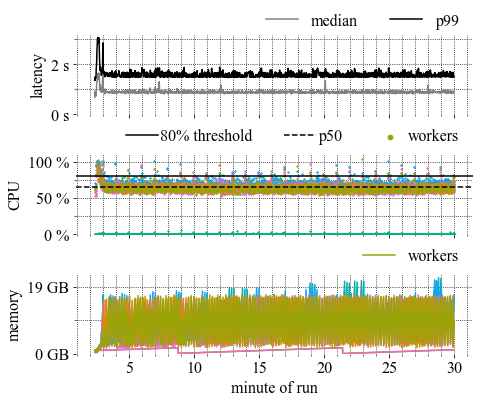

SYSTEM LOAD AVERAGE
---------------------


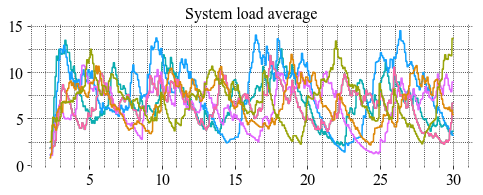

CORE METRICS
---------------------


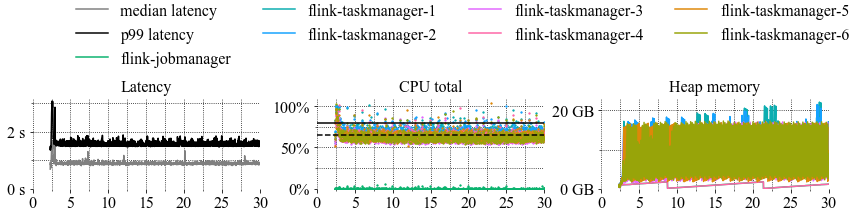

CPU
---------------------


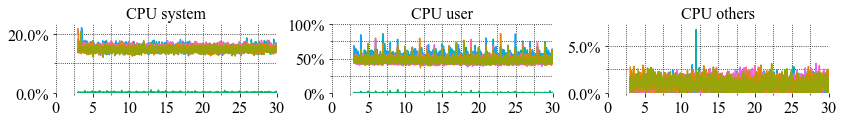

MEMORY
---------------------


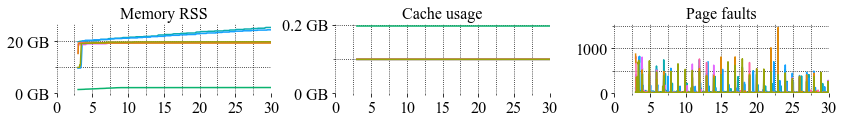

GC
---------------------


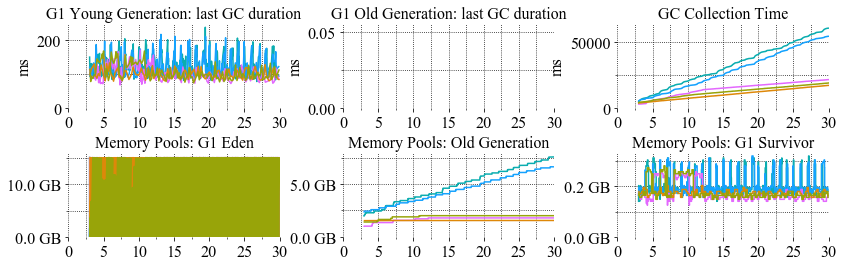

FILESYSTEM and DISK
---------------------


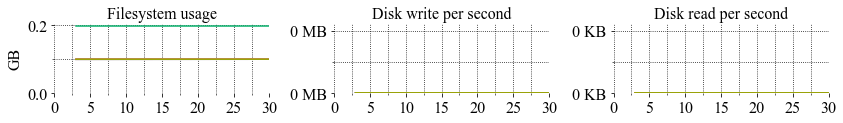

NETWORK
---------------------


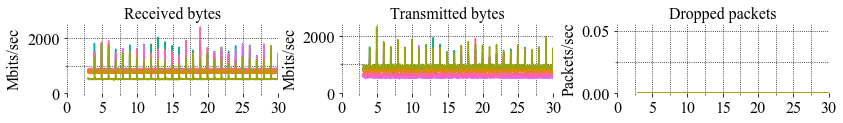

+-------------+-----------------+----------------+----------------+
|total_rxMbits|    total_txMbits|      total_rxGb|      total_txGb|
+-------------+-----------------+----------------+----------------+
|   5839461.46|5442561.010000005|5702.59908203125|5315.00098632813|
+-------------+-----------------+----------------+----------------+

TOTAL NETWORK
---------------------


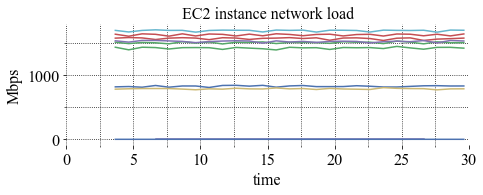

KAFKA
---------------------


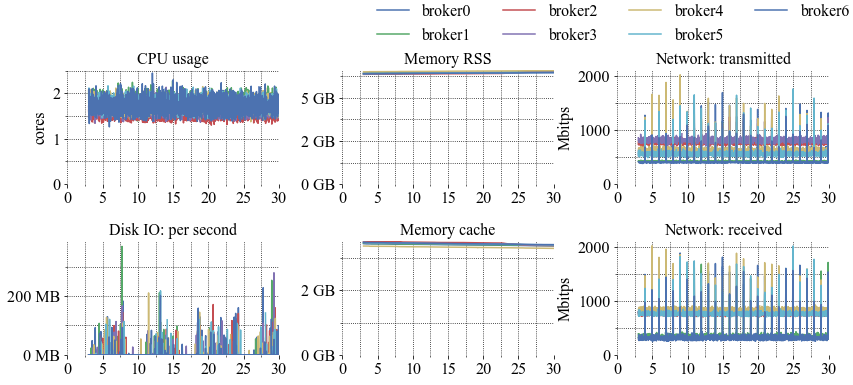

HDFS
---------------------


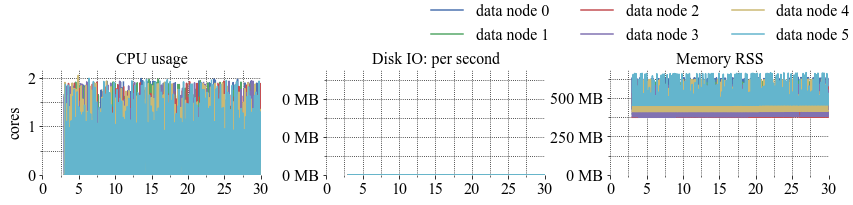

In [9]:
framework="FLINK"
stage="3"
clusterSize="baseline"
workload="constant-rate"
amt_workers = "6"
cpu_amt = "6"
memory = "30"
clusterSize = amt_workers + "x-" + cpu_amt + "cpu-" + memory + "gb"
runid="2021-01-06T17_17_46Z-c2e766ba-8107-4693-b92c-0130423f9dd5"
printTimeseriesChartNew(framework, workload, stage, clusterSize, runid, cpu_amt)

FLINK/constant-rate/101/6x-6cpu-30gb/2020-12-23T14_07_01Z-cea1d0f7-38fb-4cd3-b5d5-60da6c8ef9b1
+-----+----+-----+-----------------+-------+------+------------+
|scale| p50|  p99|         mean_cpu|  count|    TP|mean_cpu_pct|
+-----+----+-----+-----------------+-------+------+------------+
| 1500|5693|25185|4.795864865138109|5552640|285190|        80.0|
+-----+----+-----+-----------------+-------+------+------------+

CORE METRICS
---------------------


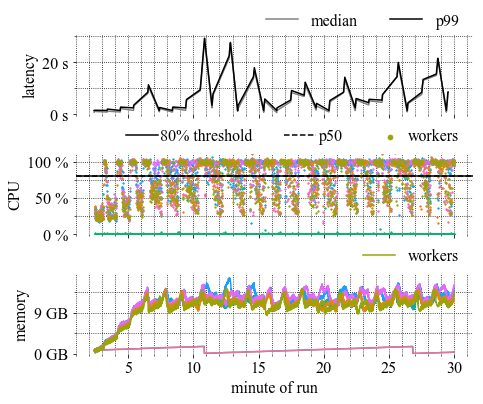

SYSTEM LOAD AVERAGE
---------------------


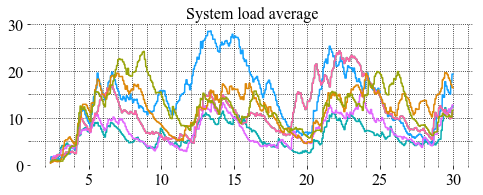

CORE METRICS
---------------------


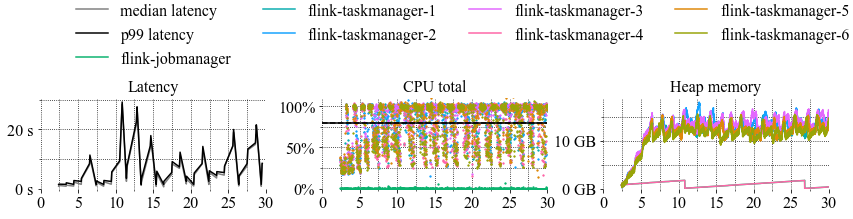

CPU
---------------------


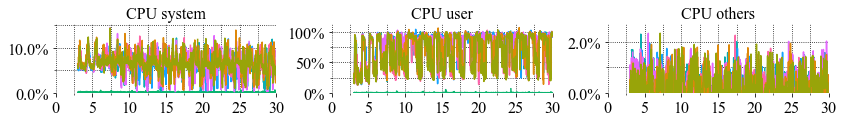

MEMORY
---------------------


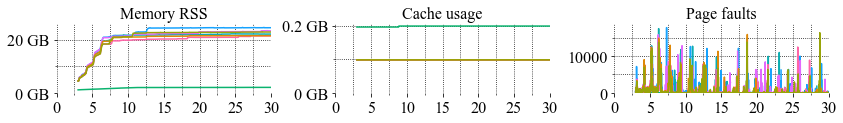

GC
---------------------


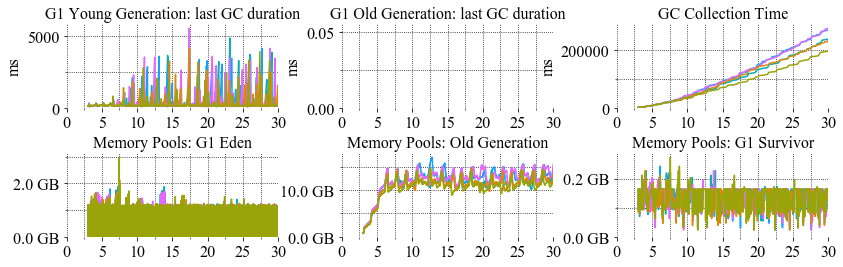

FILESYSTEM and DISK
---------------------


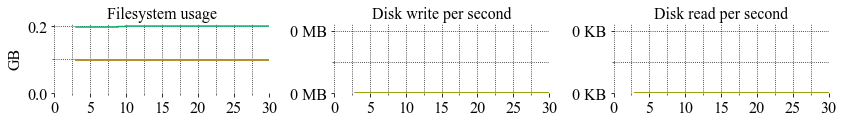

NETWORK
---------------------


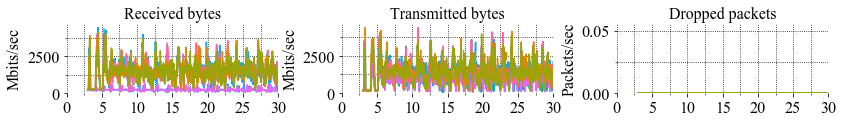

+-----------------+-----------------+------------------+-----------------+
|    total_rxMbits|    total_txMbits|        total_rxGb|       total_txGb|
+-----------------+-----------------+------------------+-----------------+
|8359381.089999993|9372052.819999987|8163.4580957031185|9152.395332031238|
+-----------------+-----------------+------------------+-----------------+

TOTAL NETWORK
---------------------


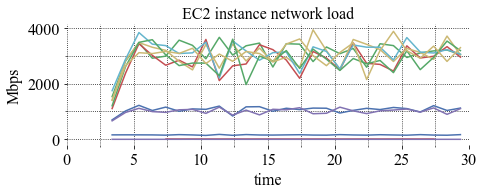

KAFKA
---------------------


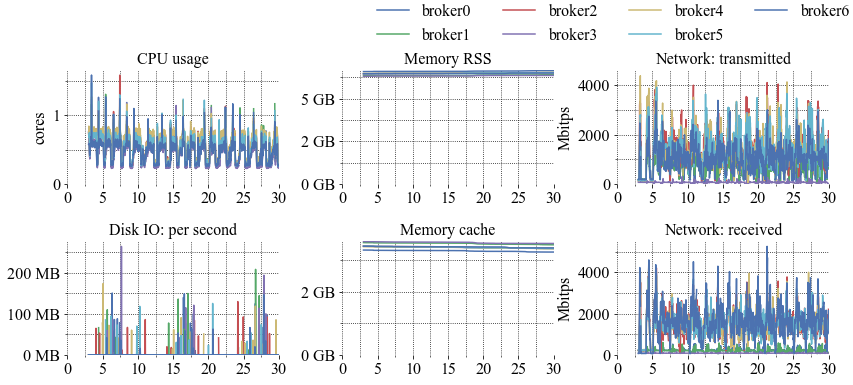

HDFS
---------------------


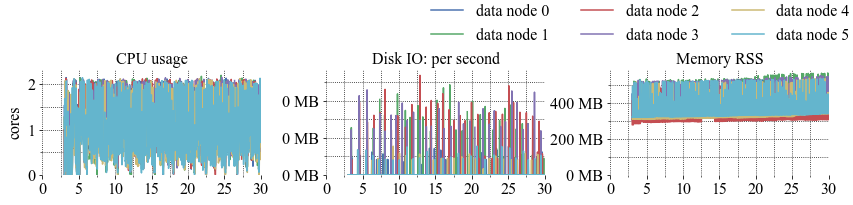

In [12]:
framework="FLINK"
stage="101"
clusterSize="baseline"
workload="constant-rate"
amt_workers = "6"
cpu_amt = "6"
memory = "30"
clusterSize = amt_workers + "x-" + cpu_amt + "cpu-" + memory + "gb"
runid="2020-12-23T14_07_01Z-cea1d0f7-38fb-4cd3-b5d5-60da6c8ef9b1"
printTimeseriesChartNew(framework, workload, stage, clusterSize, runid, cpu_amt)

SPARK/constant-rate/101/6x-1cpu-5gb/2020-12-18T17_44_05Z-88c0d562-8e7e-4229-a7c5-551c85ab0cae
+-----+-----+------+------------------+-------+------+------------+
|scale|  p50|   p99|          mean_cpu|  count|    TP|mean_cpu_pct|
+-----+-----+------+------------------+-------+------+------------+
|  550|33735|157125|0.5286164145259759|2245813|104690|        53.0|
+-----+-----+------+------------------+-------+------+------------+

CORE METRICS
---------------------


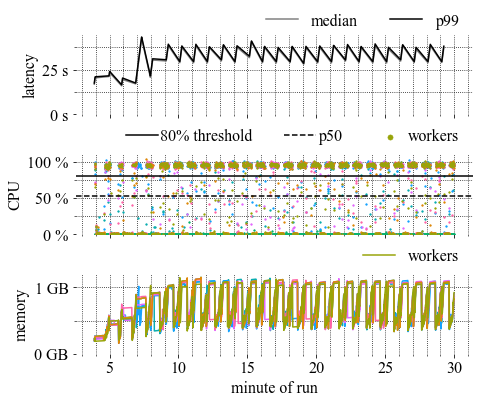

SYSTEM LOAD AVERAGE
---------------------


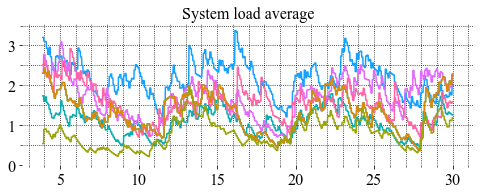

CORE METRICS
---------------------


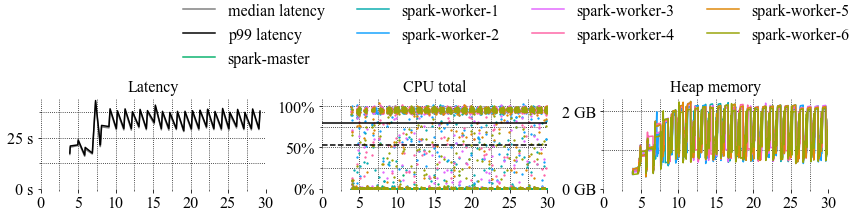

CPU
---------------------


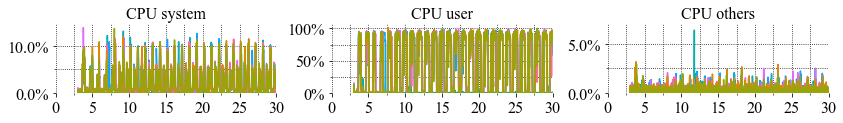

MEMORY
---------------------


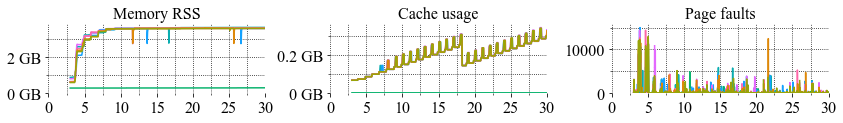

GC
---------------------


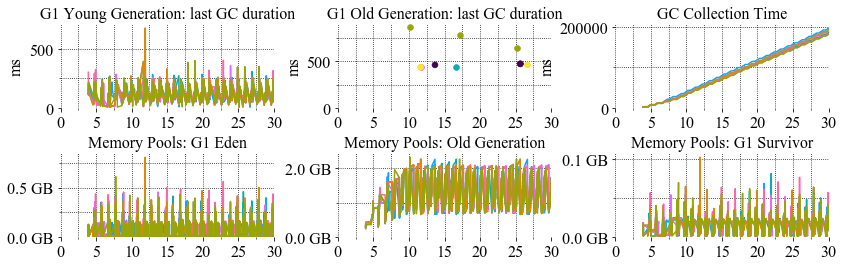

FILESYSTEM and DISK
---------------------


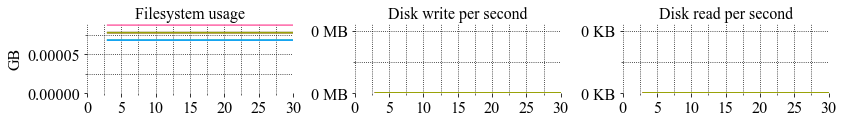

NETWORK
---------------------


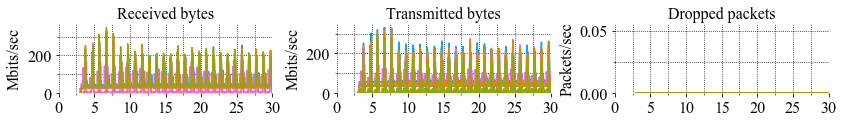

+----------------+------------------+----------------+------------------+
|   total_rxMbits|     total_txMbits|      total_rxGb|        total_txGb|
+----------------+------------------+----------------+------------------+
|431412.299999999|410862.35000000003|421.301074218749|401.23276367187503|
+----------------+------------------+----------------+------------------+

TOTAL NETWORK
---------------------


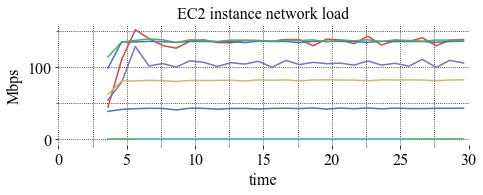

KAFKA
---------------------


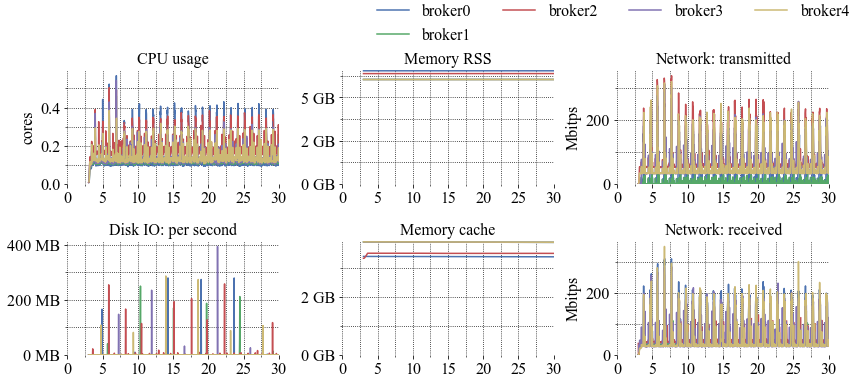

HDFS
---------------------


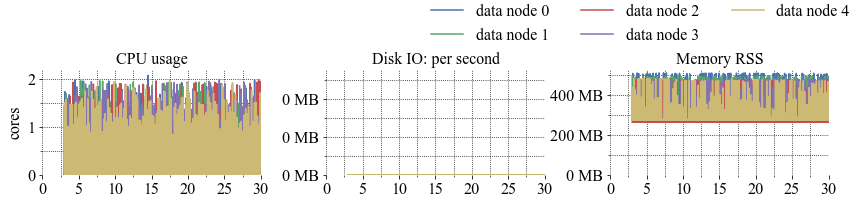

In [13]:
framework="SPARK"
stage="101"
clusterSize="baseline"
workload="constant-rate"
amt_workers = "6"
cpu_amt = "1"
memory = "5"
clusterSize = amt_workers + "x-" + cpu_amt + "cpu-" + memory + "gb"
runid="2020-12-18T17_44_05Z-88c0d562-8e7e-4229-a7c5-551c85ab0cae"
printTimeseriesChartNew(framework, workload, stage, clusterSize, runid, cpu_amt)

SPARK/constant-rate/101/6x-1cpu-5gb/2020-12-18T17_44_05Z-88c0d562-8e7e-4229-a7c5-551c85ab0cae
+-----+-----+------+------------------+-------+------+------------+
|scale|  p50|   p99|          mean_cpu|  count|    TP|mean_cpu_pct|
+-----+-----+------+------------------+-------+------+------------+
|  550|33735|157125|0.5286164145259759|2245813|104690|        53.0|
+-----+-----+------+------------------+-------+------+------------+

CORE METRICS
---------------------


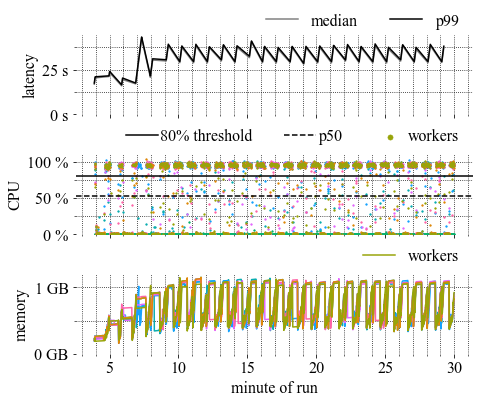

SYSTEM LOAD AVERAGE
---------------------


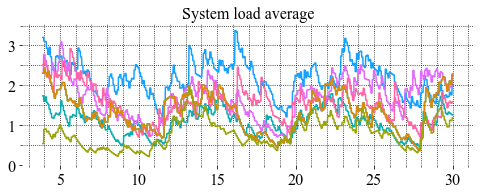

CORE METRICS
---------------------


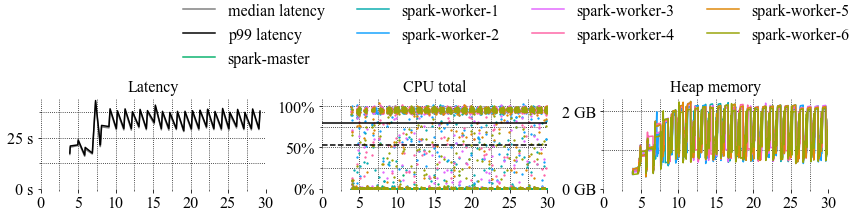

CPU
---------------------


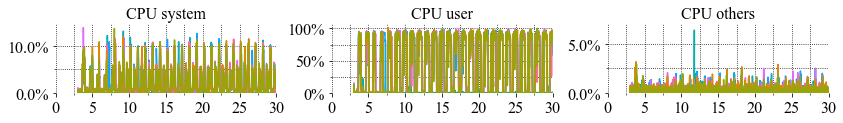

MEMORY
---------------------


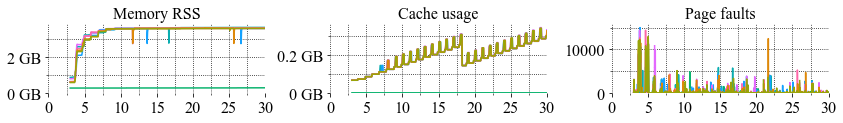

GC
---------------------


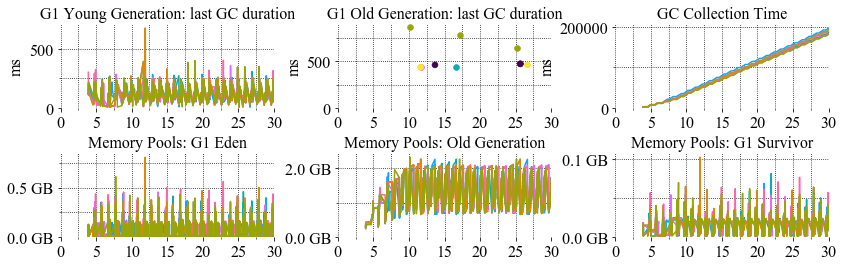

FILESYSTEM and DISK
---------------------


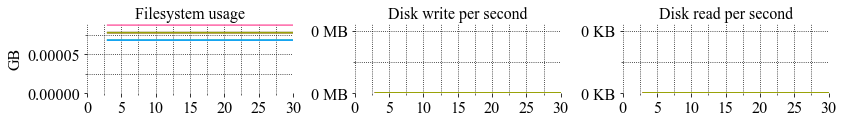

NETWORK
---------------------


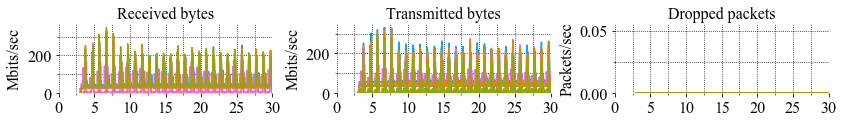

+----------------+------------------+----------------+------------------+
|   total_rxMbits|     total_txMbits|      total_rxGb|        total_txGb|
+----------------+------------------+----------------+------------------+
|431412.299999999|410862.35000000003|421.301074218749|401.23276367187503|
+----------------+------------------+----------------+------------------+

TOTAL NETWORK
---------------------


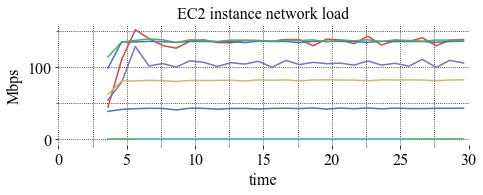

KAFKA
---------------------


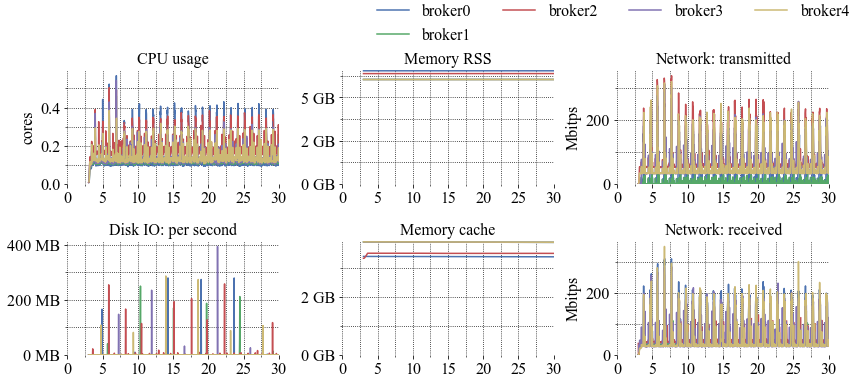

HDFS
---------------------


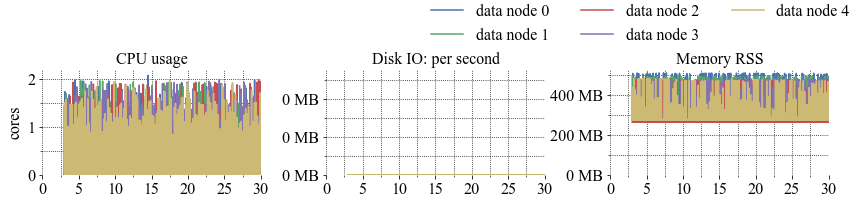

In [14]:
framework="SPARK"
stage="101"
clusterSize="baseline"
workload="constant-rate"
amt_workers = "6"
cpu_amt = "1"
memory = "5"
clusterSize = amt_workers + "x-" + cpu_amt + "cpu-" + memory + "gb"
runid="2020-12-18T17_44_05Z-88c0d562-8e7e-4229-a7c5-551c85ab0cae"
printTimeseriesChartNew(framework, workload, stage, clusterSize, runid, cpu_amt)